# Importing Libraries & CSV

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('default')

# Star identification (can be modified as needed)
#TIC, star = 'TIC 276252961', 'BH Lyn'
#TIC, star = 'TIC 243247640', 'DV Uma'
#TIC, star = 'TIC 285019418', 'DW Uma'
#TIC, star = 'TIC 219107776', 'EX Dra'
#TIC, star = 'TIC 22592859', 'V808 Aur'
#TIC, star = 'TIC 238609772', 'GY Cnc'
#TIC, star = 'TIC 52861041', 'HT Cas'
#TIC, star = 'TIC 243107445', 'IP Peg'
TIC, star = 'TIC 440666925', 'PX And'
#TIC, star = 'TIC 1102138697', 'OV Boo'

current_star = star + " (" + TIC + ")"
cadence_magnifier = 10
cadence = 120
no_test_chunks = 100000

# Read data from CSV file
def read_csv_data(filename):
    """
    Read lightcurve data from CSV file.
    Expected columns: 'time' (in JD) and 'flux' (normalized flux values)
    """
    try:
        df = pd.read_csv(filename)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        
        print(f"Available columns: {list(df.columns)}")
        print(f"First few rows:\n{df.head()}")
        
        # Check for required columns (case insensitive)
        time_col = None
        flux_col = None
        
        for col in df.columns:
            if col.lower() in ['time', 'jd', 'bjd', 'hjd']:
                time_col = col
            elif col.lower() in ['flux', 'magnitude', 'mag', 'brightness']:
                flux_col = col
        
        if time_col is None or flux_col is None:
            print(f"Available columns: {list(df.columns)}")
            raise ValueError("Could not find time and flux columns in CSV")
        
        print(f"Using columns: {time_col} (time), {flux_col} (flux)")
        
        # Convert to numeric, coercing errors to NaN
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df[flux_col] = pd.to_numeric(df[flux_col], errors='coerce')
        
        # Remove NaN values and any rows with non-numeric data
        df = df[[time_col, flux_col]].dropna()
        
        # Ensure we have data after cleaning
        if len(df) == 0:
            raise ValueError("No valid numeric data found after cleaning")
        
        # Convert magnitude to flux if needed (assuming magnitude column)
        if flux_col.lower() in ['magnitude', 'mag']:
            # Convert magnitude to relative flux (higher mag = lower flux)
            flux_values = 10**(-0.4 * (df[flux_col] - df[flux_col].median()))
        else:
            flux_values = df[flux_col].values
        
        # Ensure data is in proper numeric format for lightkurve
        time_values = np.array(df[time_col].values, dtype=np.float64)
        flux_values = np.array(flux_values, dtype=np.float64)
        
        # Remove any infinite values
        finite_mask = np.isfinite(time_values) & np.isfinite(flux_values)
        time_values = time_values[finite_mask]
        flux_values = flux_values[finite_mask]
        
        print(f"Loaded {len(time_values)} valid data points from {filename}")
        print(f"Time range: {time_values.min():.2f} to {time_values.max():.2f}")
        print(f"Flux range: {flux_values.min():.6f} to {flux_values.max():.6f}")
        
        return time_values, flux_values
        
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        raise


Available columns: ['JD', 'Magnitude']
First few rows:
             JD  Magnitude
0  2.457860e+06     16.178
1  2.457860e+06     16.217
2  2.457860e+06     16.254
3  2.457860e+06     16.151
4  2.457860e+06     16.111
Using columns: JD (time), Magnitude (flux)
Loaded 40074 valid data points from aavso_data.csv
Time range: 2457860.46 to 2457899.96
Flux range: 0.059539 to 5.262596
Created 5 lightcurve segments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40074 entries, 0 to 40073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    40074 non-null  float64
 1   flux    40074 non-null  float64
dtypes: float64(2)
memory usage: 626.3 KB


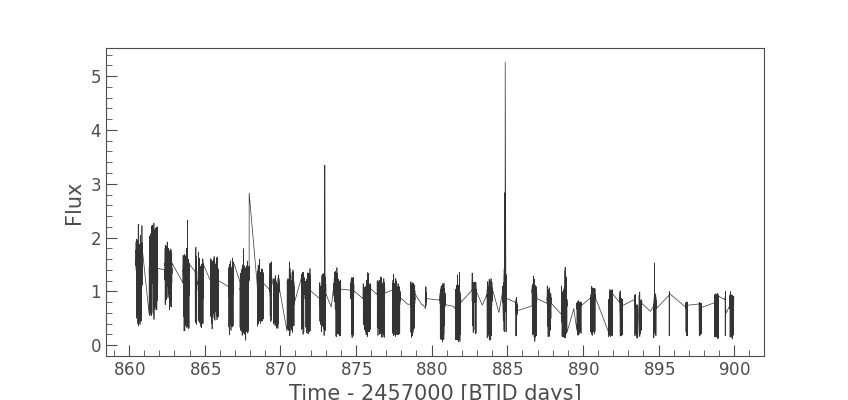

In [9]:
# Function to create lightcurve objects from CSV data
def create_lightcurves_from_csv(filename, chunk_size=None):
    """
    Create lightkurve LightCurve objects from CSV data.
    If chunk_size is provided, split data into chunks to simulate multiple sectors.
    """
    time_data, flux_data = read_csv_data(filename)
    
    lcs = []
    
    if chunk_size is None or len(time_data) <= chunk_size:
        # Create single lightcurve with explicit astropy units
        lc = lk.LightCurve(time=time_data, flux=flux_data, 
                          time_format='jd', flux_unit='electron/s')
        lcs.append(lc)
    else:
        # Split into chunks to simulate multiple sectors
        num_chunks = len(time_data) // chunk_size
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(time_data))
            
            chunk_time = time_data[start_idx:end_idx]
            chunk_flux = flux_data[start_idx:end_idx]
            
            lc = lk.LightCurve(time=chunk_time, flux=chunk_flux,
                              time_format='jd', flux_unit='electron/s')
            lcs.append(lc)
        
        # Add remaining data if any
        if len(time_data) % chunk_size != 0:
            remaining_time = time_data[num_chunks * chunk_size:]
            remaining_flux = flux_data[num_chunks * chunk_size:]
            lc = lk.LightCurve(time=remaining_time, flux=remaining_flux,
                              time_format='jd', flux_unit='electron/s')
            lcs.append(lc)
    
    print(f"Created {len(lcs)} lightcurve segments")
    return lcs

# Load data from CSV file instead of TESS archive
try:
    lcs = create_lightcurves_from_csv('aavso_data.csv', chunk_size=10000)  # Adjust chunk_size as needed
    lightcurve = combine_lightcurves(lcs)
    lightcurve.plot()
except Exception as e:
    print(f"Failed to load data: {e}")
    print("Please ensure 'aavso_data.csv' exists and contains 'time' and 'flux' columns")
    # Exit or provide alternative data loading method
    raise



# Periodogram

Guessed peak width is 0.01265706788596513
5925


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': 'b8f37244-cbd5-45a1-a9c0-e8d895eb0708',
              'x': {'bdata': ('sir5PxVypz8gdSAGJ9m2P31WfCbCvb' ... 'kzCZ81QJsVAr9uUjZAZxVfOyWeNkA='),
                    'dtype': 'f8'},
              'y': {'bdata': ('nuWtdCWyxj9eHiWIAHS6PxWSPyb7Wr' ... 'dBtUC2P83iIQHx060/ECjo4LSxsD8='),
                    'dtype': 'f8'}},
             {'line': {'color': 'black'},
              'mode': 'lines',
              'name': 'Periodogram',
              'type': 'scatter',
              'uid': '0075ca69-041b-47a8-9177-feedbdfa3043',
              'x': {'bdata': ('Qa7aUMK8dD9BrtpQwryEP2IFSHkjG4' ... 'hLPbT8PUCGRnAJAP49QDFUldVL/z1A'),
                    'dtype': 'f8'},
              'y': {'bdata': ('YoiBJmlf1D+J3Xil6TLUP0SM7corvd' ... 'DjHQ85ZD/hj64SMfBVP1qXisvrgzg/'),
                    'dtype': 'f8'}}],
    'layout': {'

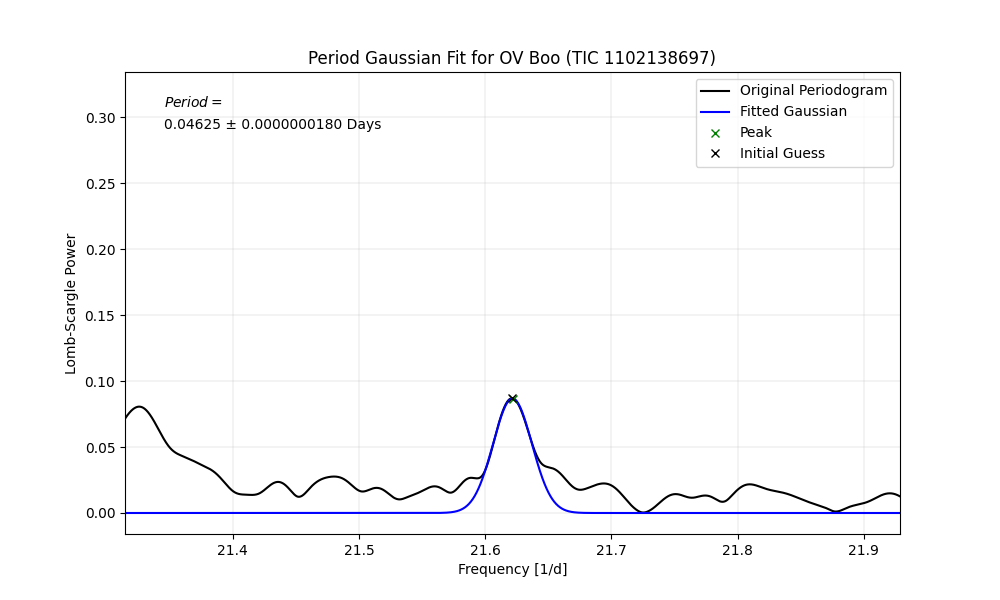

In [11]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 30)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(f'Guessed peak width is {peak_width}')
max_power = periodogram.max_power.value
optimized_parameters_global = []

frequencies = periodogram.frequency.value
print(len(frequencies))
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})
periodogram_df = pd.DataFrame({'frequencies': f, 'power': p})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

global_periods_uncertainities = []
global_periods = []

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        point_freq = peaks_df['frequencies'][i]

        zoomed_df = periodogram_df[periodogram_df['frequencies'].between(point_freq - (1.5*peak_width), point_freq + (1.5*peak_width))]

        optimized_parameters, covariance = optimize.curve_fit(gaussian, zoomed_df['frequencies'], zoomed_df['power'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)
        fitted_gaussian_again = gaussian(f, amp, cen, wid)

        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])


        fig, ax = plt.subplots(figsize = (10, 6))
        ax.plot(f, p, label = "Original Periodogram", color = 'black')
        # ax.plot(zoomed_df['frequencies'], zoomed_df['power'], label = "Zoomed Periodogram", color = 'red')
        ax.plot(f, fitted_gaussian_again, label = 'Fitted Gaussian', color = 'blue')
        ax.plot(cen, amp, 'x', label = 'Peak', color = 'green')        
        ax.plot(initial_guess[1], initial_guess[0], 'x', label = 'Initial Guess', color = 'black')
        ax.set_xlim(cen - 20*wid, cen + 20*wid)
        ax.set_title(f'Period Gaussian Fit for {current_star}')
        ax.set_xlabel('Frequency [1/d]')
        ax.set_ylabel('Lomb-Scargle Power')


        period_uncertainity = float(np.sqrt(covariance[1, 1]))/(cen**2)
        global_periods_uncertainities.append(period_uncertainity)
        global_periods.append(1/cen)

        period_here = f"{round(1/cen, 6)} ± {period_uncertainity:.10f} Days"

        print(f'Period is {1/cen} ± {period_uncertainity:.10f} Days')
        print("Ucertainity in seconds is ", period_uncertainity*24*60*60)

        plt.text(0.05, 0.95, f'$Period =$', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')
        plt.text(0.05, 0.90, f'{round(1/cen, 6)} ± {period_uncertainity:.10f} Days', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')
        

        ax.grid(True, linewidth = 0.2)
        ax.legend(loc = 'upper right')
    
scatter.on_click(update_point)
fi


In [12]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

old_fitted_period = fitted_period.copy()

Fitted Frequency: 21.621684568899685
Fitted Period: 0.04624986535223002


# Dividing Data Into Chunks

In [ ]:
# Dividing the lightcurve into chunks, the size of a chunk is the fitted period.
# Fixed to work with both TESS and CSV data


# Check what time format is available and use appropriate one
try:
    # Try TESS format first (btjd)
    time_data = lightcurve.time.btjd
    time_format = "btjd"
    print("Using TESS btjd time format")
except AttributeError:
    try:
        # Try regular Julian Date
        time_data = lightcurve.time.jd
        time_format = "jd" 
        print("Using Julian Date time format")
    except AttributeError:
        # Fallback to raw time values
        time_data = lightcurve.time.value
        time_format = "value"
        print("Using raw time values")

# Create DataFrame with proper time data
lightcurve_df = pd.DataFrame({
    'time': time_data, 
    'flux': np.array(lightcurve.flux, dtype='f')
})

# Remove any NaN or infinite values
lightcurve_df = lightcurve_df.replace([np.inf, -np.inf], np.nan).dropna()

# Sort by time to ensure proper order
lightcurve_df = lightcurve_df.sort_values('time').reset_index(drop=True)

print(f"Using {len(lightcurve_df)} data points for chunking")
print(f"Time range: {lightcurve_df['time'].min():.6f} to {lightcurve_df['time'].max():.6f}")
print(f"Time format: {time_format}")

# Check if we have enough data
if len(lightcurve_df) == 0:
    raise ValueError("No valid data points available for chunking")

# --- Apply phase offset here ---
curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period
chunks = []
chunk_centres = []
all_chunk_count = None

print(f"Fitted period: {fitted_period} days")
print(f"Expected chunk size: {fitted_period / (np.median(np.diff(lightcurve_df['time'].values))):.1f} points")

for i in tqdm(range(1, no_test_chunks+1)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        all_chunk_count = i
        print(f"Reached end of data at chunk {i}")
        break
    else:
        # Only the timestamps between initial_time and end_time are stored inside a chunk.
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] < curr_end_time)]
        
        # Move to next chunk
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period
        
        # Calculate expected length based on ACTUAL data cadence, not assumed cadence
        time_diffs = np.diff(lightcurve_df['time'].values)
        actual_cadence_days = np.median(time_diffs)  # Median cadence in days
        actual_cadence_seconds = actual_cadence_days * 86400  # Convert to seconds
        
        # Use actual cadence for expected length calculation
        expected_length = fitted_period / actual_cadence_days
        chunk_length = len(chunk)
        
        # More lenient length requirements for CSV data
        min_length = 0.3 * expected_length  # Very lenient for irregular data
        max_length = 3.0 * expected_length  # Very lenient for irregular data
        
        if (chunk_length < max_length) and (chunk_length > min_length) and (chunk_length > 0):
            chunks.append(chunk)
            chunk_centres.append(curr_initial_time - (fitted_period/2))
        elif chunk_length > 0:
            # Only print rejection info for first few chunks to avoid spam
            if i <= 10:
                print(f"Chunk {i}: length {chunk_length:.0f}, expected {expected_length:.0f} (range {min_length:.0f}-{max_length:.0f}) - rejected")

if not all_chunk_count:
    all_chunk_count = no_test_chunks

chunk_lengths = [len(chunk) for chunk in chunks]
if len(chunk_lengths) > 0:
    avg_chunk_length = pd.Series(chunk_lengths).mean()
    print(f'Number of chunks is {len(chunks)}')
    print(f'Mean of chunk lengths is {avg_chunk_length:.1f}')
    print(f'Chunk length range: {min(chunk_lengths)} to {max(chunk_lengths)}')
else:
    print("WARNING: No valid chunks created!")
    print("This might indicate:")
    print("- Fitted period is too large/small for your data")
    print("- Data cadence doesn't match expected cadence")
    print("- Time gaps in data are too large")
    
    # Diagnostic information
    total_time_span = lightcurve_df['time'].max() - lightcurve_df['time'].min()
    print(f"Total time span: {total_time_span:.2f} days")
    print(f"Fitted period: {fitted_period:.2f} days")
    print(f"Expected chunks: {total_time_span / fitted_period:.1f}")
    
    # Show data cadence
    time_diffs = np.diff(lightcurve_df['time'].values)
    median_cadence = np.median(time_diffs) * 86400  # Convert to seconds
    print(f"Actual median cadence: {median_cadence:.1f} seconds")
    print(f"Expected cadence: {cadence / cadence_magnifier:.1f} seconds")

Using TESS btjd time format
Using 40074 data points for chunking
Time range: 860.461341 to 899.964961
Time format: btjd
Fitted period: 0.04624986535223002 days
Expected chunk size: 159.5 points


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 75/100000 [00:00<02:14, 743.90it/s]

Chunk 4: length 496, expected 159 (range 48-478) - rejected
Chunk 5: length 606, expected 159 (range 48-478) - rejected
Chunk 6: length 543, expected 159 (range 48-478) - rejected


  1%|          | 854/100000 [00:01<02:19, 708.90it/s]

Reached end of data at chunk 855
Number of chunks is 266
Mean of chunk lengths is 134.6
Chunk length range: 48 to 427


## Adjusting the Phase of Chunks
If the expected dip is not present in your chunks, you can shift the phase of the chunking by setting the `phase_offset_days` parameter below. This value (in days) will shift the starting point of the chunking process forward (positive) or backward (negative). Adjust this parameter in small steps (e.g., 0.05 × period) until the dip appears in the desired chunk.

**How to use:**
- Set `phase_offset_days = 0.0` for no shift (default).
- Increase or decrease the value to move the chunk window in time.
- Re-run the chunking and analysis cells after changing this value.

Example: `phase_offset_days = 0.1` will shift all chunks by +0.1 days.

# INFORMING THE PROGRAM ABOUT THE POSITION OF THE GAUSSIAN

In [14]:
chunk_num = 35  # Which chunk to use for testing?

sample_chunk = chunks[chunk_num].copy()  # Make a copy to avoid modifying original
chunk_centre = chunk_centres[chunk_num]

# Invert the flux values to convert dips to peaks for Gaussian fitting
sample_chunk['flux'] = -sample_chunk['flux'] + sample_chunk['flux'].max() + sample_chunk['flux'].min()

sample_chunk_markers = sample_chunk.iloc[::10, :]

gaussian_peak_width = 0
gaussian_position_relative_to_centre = 0

chunk_fi = go.FigureWidget([
    go.Scatter(x=sample_chunk_markers['time'], y=sample_chunk_markers['flux'], mode='markers', name='Sampled Points', marker= {'symbol': 'bowtie', 'size': 10, 'color':'red'}),
    go.Scatter(x=sample_chunk['time'], y=sample_chunk['flux'], mode='lines', name='Chunk', line=dict(color='blue')),
], layout = go.Layout(title=f'Sample Chunk Gaussian Fit for {current_star} (Inverted)', xaxis_title='Time [BTJD]', yaxis_title='Inverted Flux', autosize=False, width = 1500, height=700, yaxis=dict(autorange='reversed')))

chunk_scatter = chunk_fi.data[0]
chunk_fi.layout.hovermode = 'closest'


def first_input(trace, points, selector):
    '''
    This function is used to store the first point clicked in the chunk.
    '''
    global point1_time
    global point1_flux
    point1_time = points.xs[0]
    point1_flux = points.ys[0]

def gaussian_func(x, amplitude, center, width, baseline):
    """Inverted Gaussian function with baseline (for dips)"""
    return amplitude * np.exp(-0.5 * ((x - center) / width) ** 2) + baseline

def second_input(trace, points, selector):
    '''
    Takes in the second point clicked and fits a gaussian to the chunk. The main function is to get the peak width and position relative to the centre.
    '''
    global point2_time
    global point2_flux
    global gaussian_peak_width
    global gaussian_position_relative_to_centre
    point2_time = points.xs[0]
    point2_flux = points.ys[0]

    gaussian_peak_width = abs(point2_time - point1_time)
    gaussian_position_relative_to_centre = (point2_time + point1_time)/2 - chunk_centre

    # Better initial parameter estimation
    baseline = np.median(sample_chunk['flux'])  # Use median as baseline
    peak_height = sample_chunk['flux'].max() - baseline  # Height above baseline
    center_time = (point2_time + point1_time) / 2  # Center between clicked points
    sigma = gaussian_peak_width / 2.355  # Convert FWHM to sigma (FWHM ≈ 2.355 * sigma)
    
    initial_guess = [peak_height, center_time, sigma, baseline]
    
    # Set reasonable bounds for parameters
    bounds = (
        [0, sample_chunk['time'].min(), 0, sample_chunk['flux'].min()],  # Lower bounds
        [sample_chunk['flux'].max(), sample_chunk['time'].max(), 
         gaussian_peak_width * 2, sample_chunk['flux'].max()]  # Upper bounds
    )
    
    try:
        # Use curve_fit with bounds and increased maxfev
        optimized_parameters, covariance = optimize.curve_fit(
            gaussian_func, 
            sample_chunk['time'], 
            sample_chunk['flux'], 
            p0=initial_guess,
            bounds=bounds,
            maxfev=2000  # Increase max function evaluations
        )
        amp, cen, wid, base = optimized_parameters
        
        # Calculate fitted and initial (guessed) curves as dips
        fitted_gaussian = gaussian_func(sample_chunk['time'], amp, cen, wid, base)
        initial_gaussian = gaussian_func(sample_chunk['time'], *initial_guess)
        
        # Add traces to plot
        chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=fitted_gaussian, mode='lines', 
                                    name='Fitted Gaussian', line=dict(color='green', width=3)))
        chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=initial_gaussian, mode='lines', 
                                    name='Initial Gaussian', line=dict(color='orange', dash='dot')))
        chunk_fi.add_trace(go.Scatter(x=[cen, cen], y=[sample_chunk['flux'].min(), sample_chunk['flux'].max()], 
                                    mode='lines', name='Fitted Eclipse Centre', line=dict(color='red', dash='dash')))
        
        # Print fit results
        print(f"Fit Results:")
        print(f"  Amplitude: {amp:.6f}")
        print(f"  Center: {cen:.6f}")
        print(f"  Width (sigma): {wid:.6f}")
        print(f"  FWHM: {wid * 2.355:.6f}")
        print(f"  Baseline: {base:.6f}")
        
        # Update global variables
        gaussian_peak_width = wid * 2.355  # Store as FWHM
        gaussian_position_relative_to_centre = cen - chunk_centre
        
    except Exception as e:
        print(f"Gaussian fitting failed: {e}")
        print("Try clicking closer to the peak or adjusting the selection")
        print(f"Initial guess was: amp={peak_height:.3f}, cen={center_time:.3f}, width={sigma:.3f}, base={baseline:.3f}")

current_func = first_input

def toggle_clicker(trace, points, state):
    global current_func
    current_func(trace, points, state)

    # Switch to the other function
    if current_func == first_input:
        current_func = second_input
    else:
        current_func = first_input

chunk_scatter.on_click(toggle_clicker)
chunk_fi

FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 10, 'symbol': 'bowtie'},
              'mode': 'markers',
              'name': 'Sampled Points',
              'type': 'scatter',
              'uid': '865dea58-8cfa-47f6-a99f-1a24fefead7d',
              'x': {'bdata': ('AKDyf58Ei0AA4Em+qgSLQADQWwy2BI' ... 'w17wSLQACgYoj0BItAALBGKfkEi0A='),
                    'dtype': 'f8'},
              'y': {'bdata': ('F8SMPx4meT8OZ40/zjeEP+i+Uj84fT' ... '/ahk8/ItPdP4aEfj8En4E/XKVsPw=='),
                    'dtype': 'f4'}},
             {'line': {'color': 'blue'},
              'mode': 'lines',
              'name': 'Chunk',
              'type': 'scatter',
              'uid': '32f50bce-66cd-4618-a986-7bdffe5e597c',
              'x': {'bdata': ('AKDyf58Ei0AAYE6goASLQADga7uhBI' ... 'F1/ASLQABw4Sz9BItAAFAYR/0Ei0A='),
                    'dtype': 'f8'},
              'y': {'bdata': ('F8SMP4e1ij/CCII//YmDP1j/dT/+kI' ... '/qe2E/p8qAP6ZAVj8g644/qipoPw=='),
                    'dtype': '

IndexError: list index out of range

# Fitting Gaussians into Chunks

In [15]:
#List to store all the times of the peak of the gaussian.
observed_centers = []

for i in tqdm(range(len(chunks))):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, chunks[i]['time'], chunks[i]['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

    

  7%|▋         | 19/266 [00:00<00:05, 41.26it/s]

problem at chunk 2.
Initial guess was 860.5904689850623
problem at chunk 20.
Initial guess was 862.4867134645046
problem at chunk 21.
Initial guess was 862.7179627912659
problem at chunk 22.
Initial guess was 862.7642126566182
problem at chunk 23.
Initial guess was 862.8104625219704
problem at chunk 24.
Initial guess was 863.5967102329587


 10%|▉         | 26/266 [00:02<00:30,  7.91it/s]

problem at chunk 25.
Initial guess was 863.6429600983109
problem at chunk 26.
Initial guess was 863.6892099636632
problem at chunk 27.
Initial guess was 863.7354598290154


 11%|█▏        | 30/266 [00:03<00:36,  6.48it/s]

problem at chunk 29.
Initial guess was 863.82795955972


 16%|█▌        | 42/266 [00:03<00:18, 11.95it/s]

problem at chunk 30.
Initial guess was 863.8742094250722


 18%|█▊        | 47/266 [00:04<00:17, 12.46it/s]

problem at chunk 42.
Initial guess was 864.937956328174


 20%|█▉        | 52/266 [00:04<00:14, 14.70it/s]

problem at chunk 53.
Initial guess was 865.862953635219


 21%|██        | 56/266 [00:05<00:20, 10.09it/s]

problem at chunk 55.
Initial guess was 866.602951480855
problem at chunk 56.
Initial guess was 866.6492013462073
problem at chunk 57.
Initial guess was 866.6954512115595


 22%|██▏       | 59/266 [00:06<00:29,  6.97it/s]

problem at chunk 58.
Initial guess was 866.7417010769118
problem at chunk 59.
Initial guess was 866.787950942264


 23%|██▎       | 61/266 [00:06<00:35,  5.74it/s]

problem at chunk 60.
Initial guess was 866.8342008076163


 27%|██▋       | 71/266 [00:07<00:18, 10.78it/s]

problem at chunk 62.
Initial guess was 867.3891991918433


 28%|██▊       | 74/266 [00:07<00:18, 10.28it/s]

problem at chunk 72.
Initial guess was 867.9441975760703


 30%|███       | 81/266 [00:08<00:16, 11.10it/s]

problem at chunk 80.
Initial guess was 869.3779434019901
problem at chunk 82.
Initial guess was 869.6091927287514


 32%|███▏      | 84/266 [00:09<00:23,  7.83it/s]

problem at chunk 84.
Initial guess was 869.7016924594559


 32%|███▏      | 86/266 [00:09<00:28,  6.39it/s]

problem at chunk 85.
Initial guess was 869.7479423248082
problem at chunk 86.
Initial guess was 869.7941921901604


 33%|███▎      | 88/266 [00:10<00:33,  5.34it/s]

problem at chunk 87.
Initial guess was 869.8404420555127


 36%|███▌      | 96/266 [00:10<00:17,  9.87it/s]

problem at chunk 88.
Initial guess was 869.8866919208649


 41%|████▏     | 110/266 [00:11<00:08, 17.64it/s]

problem at chunk 102.
Initial guess was 871.5979369388982


 44%|████▍     | 118/266 [00:11<00:09, 15.39it/s]

problem at chunk 114.
Initial guess was 872.8004334380568


 45%|████▌     | 121/266 [00:12<00:11, 12.83it/s]

problem at chunk 120.
Initial guess was 873.6791808797495


 47%|████▋     | 124/266 [00:12<00:12, 11.16it/s]

problem at chunk 123.
Initial guess was 873.8179304758063


 51%|█████     | 135/266 [00:13<00:07, 17.24it/s]

problem at chunk 127.
Initial guess was 874.0029299372153


 56%|█████▋    | 150/266 [00:13<00:05, 21.45it/s]

problem at chunk 149.
Initial guess was 876.8241717237026


 61%|██████    | 162/266 [00:14<00:04, 25.25it/s]

problem at chunk 151.
Initial guess was 876.9166714544072


 63%|██████▎   | 167/266 [00:14<00:04, 20.69it/s]

problem at chunk 162.
Initial guess was 877.9341684921567


 67%|██████▋   | 178/266 [00:15<00:04, 20.93it/s]

problem at chunk 168.
Initial guess was 880.570410817235


 70%|███████   | 187/266 [00:15<00:02, 29.61it/s]

problem at chunk 188.
Initial guess was 883.7154016611881


 74%|███████▍  | 197/266 [00:16<00:03, 19.79it/s]

problem at chunk 191.
Initial guess was 883.8541512572449


 80%|███████▉  | 212/266 [00:16<00:02, 24.83it/s]

problem at chunk 204.
Initial guess was 886.9528922358458


 97%|█████████▋| 258/266 [00:17<00:00, 29.99it/s]

problem at chunk 255.
Initial guess was 898.7928577660222


100%|██████████| 266/266 [00:18<00:00, 14.33it/s]

problem at chunk 259.
Initial guess was 899.4403558809537


# O-C Diagram

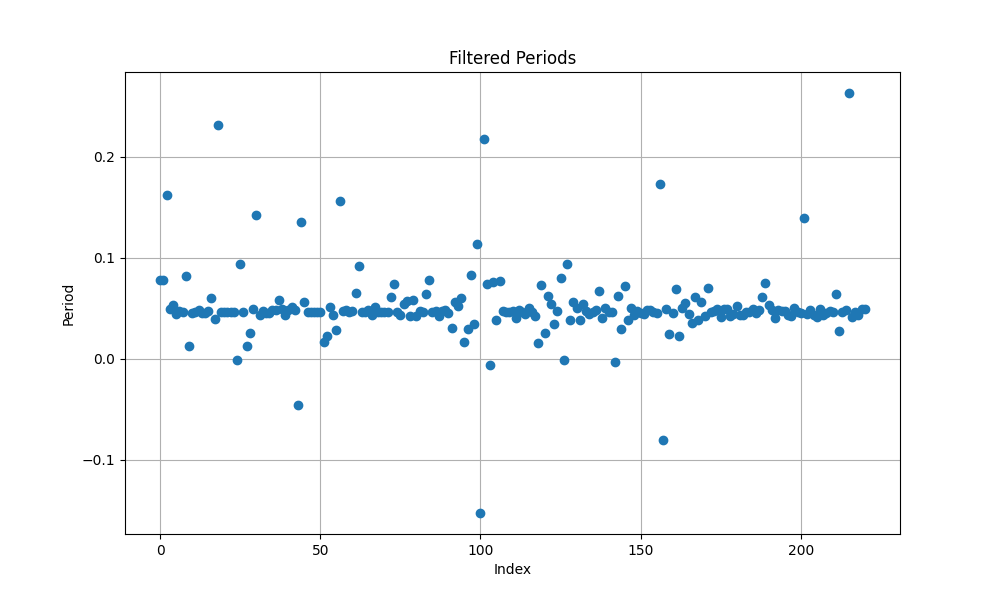

(np.float64(0.05131604374588326), np.float64(0.03597816526756029))

In [16]:
#Mean period and stuff, not required
periods_here = np.diff(observed_centers)

# Remove outliers from periods_here
mean_period = np.mean(periods_here)
std_period = np.std(periods_here)
filtered_periods = periods_here[(periods_here > mean_period - 2 * std_period) & (periods_here < mean_period + 2 * std_period)]

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)
filtered_periods = filtered_periods[(filtered_periods > mean_period - 2 * std_period) & (filtered_periods < mean_period + 2 * std_period)]

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)
filtered_periods = filtered_periods[(filtered_periods > mean_period - 2 * std_period) & (filtered_periods < mean_period + 2 * std_period)]

# Plot the filtered periods
plt.figure(figsize=(10, 6))
plt.plot(filtered_periods, marker='o', linestyle='none')
plt.title('Filtered Periods')
plt.xlabel('Index')
plt.ylabel('Period')
plt.grid(True)
plt.show()

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)

mean_period, std_period

In [25]:
lightcurve_test = lightcurve_df[: int(avg_chunk_length * no_test_chunks)]

O_C_df = pd.DataFrame(
    {
    'E' : [x for x in range(int(-1.5 * all_chunk_count ), int(1.5 * all_chunk_count))]
    }
)

#Finding the T_0 for Event number 0
centre = (lightcurve_test['time'].min() + lightcurve_test['time'].max())/2
T_0_index = np.searchsorted(observed_centers, centre, side = 'right') + 1
print(f'T_0 index is {T_0_index}')

O_C_df['C'] = observed_centers[T_0_index] + O_C_df['E'] * fitted_period

# Insert observed_centers[i] at E = int((observed_centers[i] - observed_centers[T_0_index])/fitted_period), fill the rest with NaN
O_C_df['O'] = np.nan
for i in range(len(observed_centers)):
    E_value = int(round((observed_centers[i] - observed_centers[T_0_index]) / fitted_period))
    if E_value in O_C_df['E'].values:
        O_C_df.loc[O_C_df['E'] == E_value, 'O'] = observed_centers[i]

O_C_df['O-C'] = (O_C_df['O'] - O_C_df['C'])
# O_C_df = O_C_df.dropna(inplace=False)

def parabola(x, a, b, c):
    return a*(x**2) + b*x + c

def parabola2(x, a, b, c):
    return a*((x-b)**2) + c

another_O_C = O_C_df.dropna(inplace=False)
print("Number of points in O-C:", len(another_O_C))
mean_O_C = O_C_df['O-C'].mean()

T_0 index is 88
Number of points in O-C: 633


In [26]:
#Removing the outliers

stq_up_to_remove = 0.5
stq_down_to_remove= 0.5

s = O_C_df['O-C'].std()
print("Points removed = ", len(O_C_df[O_C_df['O-C'].apply(lambda x: True if (x-mean_O_C) > stq_up_to_remove*s else (True if (x-mean_O_C) < -stq_down_to_remove*s else False))]['O-C']))
O_C_df = O_C_df[O_C_df['O-C'].apply(lambda x: False if (x-mean_O_C) > stq_up_to_remove*s else (False if (x-mean_O_C) < -stq_down_to_remove*s else True))]

print("Points removed = ", len(another_O_C[another_O_C['O-C'].apply(lambda x: True if (x-mean_O_C) > stq_up_to_remove*s else (True if (x-mean_O_C) < -stq_down_to_remove*s else False))]['O-C']))
another_O_C = another_O_C[another_O_C['O-C'].apply(lambda x: False if (x-mean_O_C) > stq_up_to_remove*s else (False if (x-mean_O_C) < -stq_down_to_remove*s else True))]


Points removed =  142
Points removed =  142


[ 2.64969261e-27  3.62352588e-10 -1.33905020e-18]
fitted_period is 0.07317634597366982
P_dot is 5.523351091520715e-13


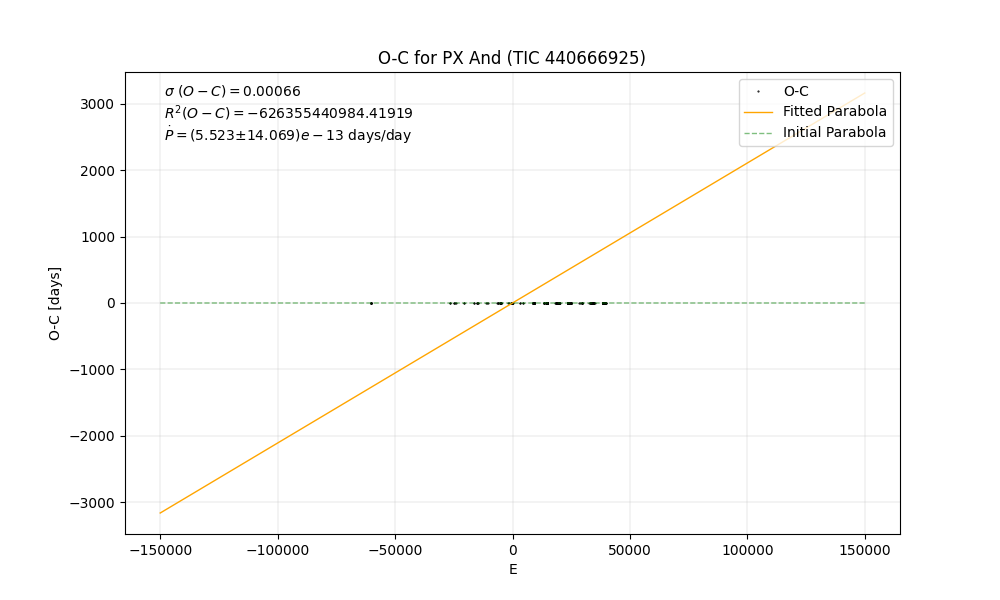

In [27]:
optimized_parameters_O_C_global = []

a = 0
b = 0
c = mean_O_C

initial_guess = [a, b, c]
optimized_parameters, covariance = optimize.curve_fit(parabola2, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

print(covariance[0])


fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
initial_parabola = parabola(O_C_df['E'], *initial_guess)


#Finding the R^2 value
residuals = O_C_df['O-C'] - fitted_parabola
ss_res = np.sum(residuals**2)
ss_tot = np.sum((O_C_df['O-C'] - O_C_df['O-C'].mean())**2)
r_squared = 1 - (ss_res / ss_tot)

optimized_parameters_O_C_global.append(optimized_parameters)

a = optimized_parameters[0]
print(f'fitted_period is {old_fitted_period}')
p_dot = (2 * a * 1/(old_fitted_period))
print(f'P_dot is {p_dot}')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(O_C_df['E'], O_C_df['O-C'], lw=0, marker='o', markersize=0.5, label = "O-C", color='black')
ax.plot(O_C_df['E'], fitted_parabola, lw=1, label = 'Fitted Parabola', color='orange')
ax.plot(O_C_df['E'], initial_parabola, lw=1, label = 'Initial Parabola', linestyle='--', alpha=0.5, color = 'green')
ax.legend(loc=1)
ax.set_title(f'O-C for {current_star}')
ax.set_xlabel('E')
ax.set_ylabel('O-C [days]')

O_C_std = O_C_df['O-C'].std()

p_dot_err = abs(p_dot * ((  (float(np.sqrt(covariance[0, 0]))/a)**2 + (global_periods_uncertainities[-1]/global_periods[-1])**2  )**(1/2)))

# Combine the values and adjust the format
base = p_dot / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Extract base
err_base = p_dot_err / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Adjust error to same base
exponent = int(f"{p_dot:.3e}".split("e")[-1])  # Get exponent

# Format the result as required
formatted_result = f"({base:.3f}  ±  {err_base:.3f})e{exponent}"


plt.text(0.05, 0.95, r'$\sigma$' + f" $(O-C) = {O_C_std:.5f}$", transform=plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.90, f'$R^2 (O-C)= {r_squared:.5f}$', transform=plt.gca().transAxes, fontsize=10)

plt.text(0.05, 0.85, f'$\dot P = {formatted_result}$ days/day', transform=plt.gca().transAxes, fontsize=10)


ax.grid(True, linewidth = 0.2)



In [28]:
df1 = pd.DataFrame({"A": [1, 2], "B":[3, 4]})
df2 = pd.DataFrame({"B": [5, 6], "D":[7, 8]})
df1 + df2
# Save the O_C_df DataFrame to CSV so it is always up to date
O_C_df.to_csv('O_C_df.csv', index=False)